In [1]:
import json
import glob
import numpy as np
import pandas as pd
import csv
import string
import re
import math
import sklearn as sk
import nltk
import heapq
import matplotlib.pyplot as plt
import pickle

**IMPORTING AND GETTING ALL LIBRARIES**

Link to download dataset: https://github.com/avadhutshelar/SmartLawDataset

In [2]:
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import pos_tag
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [3]:
#LOCATE EXACT LOCATION OF ALL JSON FILES IN KAGGLE LOCAL SETUP
train_files = glob.glob("E:/git/SmartLawDataset/json/*.json")

**EXTRACTING THE REQUIRED TEXT AND GETTING THEM INTO PROPER FORMAT**

In [4]:
#EXTRACT INDIVIDUAL FILES AND GET THEM INTO SINGLE DATAFRAME
df_final=pd.DataFrame()
for file in train_files:
    with open(file,encoding="utf8") as f1: 
        data=json.load(f1) #ALL DATA FROM FILE LOADED INTO DATA
        df=pd.DataFrame([data]) #CREATE DATAFRAME FOR SINGLE DATA
        df_final=pd.concat([df_final,df]) #MERGE ALL INDIVIDUAL DATAFRAME INTO SINGLE DATAFRAME
#MAIN AIM IS TO GENERATE ML ALGO TO DETERMINE ARGUMENT TEXT AND ARGUMENT BY SO REMOVE REST
df_final=df_final.drop(['header','background','order','footer','annotationProcessingStage','annotationProcessingStageAnnotations','processedText'],axis=1)
#AXIS=1 REMOVE COLUMNS

In [5]:
data1=[]
data2=[]
df_final1=pd.DataFrame();
for j in df_final['arguments']:
    for k in j:
        s=k['text'][3:]
        data1.append(s.strip())
        data2.append(k['argumentBy'])
df_final1['text']=data1
df_final1['by']=data2
#Use df_final1 dataframe only for further processes and not csv files to ensure encoding is in proper format
print(df_final1)

                                                  text          by
0    Perused the application and say filed by the I...       JUDGE
1    The prosecution case is that on 03.12.2018 at ...  RESPONDENT
2    The Ld. Counsel for Applicant stated that the ...   APPLICANT
3    The Ld. APP for the State submitted that, ther...  RESPONDENT
4    After hearing the submissions of both the side...       JUDGE
..                                                 ...         ...
601  Applicant Ramesh Valmiki is a clerk working in...  RESPONDENT
602  Advocate for applicants in their argument stat...   APPLICANT
603  Advocate for applicant in their argument furth...   APPLICANT
604  Ld. DGP strongly opposed this application. It ...  RESPONDENT
605  The offence is serious. In collusion with reve...       JUDGE

[606 rows x 2 columns]


In [6]:
s =  set(string.punctuation)
s.add('\xad')
for index, row in df_final1.iterrows():
    for x in row['text']:
        row['text']=row['text'].lower()
#         print(row['text'])
        if x in s or re.search(r'-?\d+', x): 
            row['text']=row['text'].replace(x,"")
#Now we have proper dataset after removing unwanted punctuations etc
bag_of_words=[]
los=[]
for item in df_final1['text']:
    los.append(item)
    for word in item.split():
        bag_of_words.append(word)

Wordset containing all words.
create dic for freq of all words in doc.
calculate tf.


**CREATING VECTORS FOR TEXTS IN ORDER TO GIVE THEM AS INPUT TO ML MODEL**

In [7]:
dict_1={}
for index,row in df_final1.iterrows():
    for word in row['text'].split():
        if word in dict_1:
            dict_1[word]+=1
        else:
            dict_1[word]=1

In [8]:
# Calculate term_freq
def compute_term_frequency(word_dictionary, bag_of_words):
    term_frequency_dictionary = {}
    length_of_bag_of_words = len(bag_of_words)

    for word, count in word_dictionary.items():
        term_frequency_dictionary[word] = count / float(length_of_bag_of_words)

    return term_frequency_dictionary

In [9]:
dict_2={}
dict_3={}
for item in los:
    for word in item.split():
        if word in dict_2 and word not in dict_3:
            dict_2[word]+=1
            dict_3[word]=1
        else:
            if word not in dict_2:
                dict_2[word]=1
                dict_3[word]=1
    dict_3.clear()

In [10]:
#Calculate inverse doc_freq
def compute_inverse_document_frequency(full_doc_list):
    idf_dict = {}
    length_of_doc_list = len(full_doc_list)

    idf_dict = dict.fromkeys(full_doc_list.keys(), 0)
    for word, value in idf_dict.items():
        idf_dict[word] = math.log(length_of_doc_list / (float(value) + 1))

    return idf_dict

final_idf_dict = compute_inverse_document_frequency(dict_2)

In [11]:
#Create a TFIDF vectorizer to generate text entered into vector form to be given as input to Machine Learning model
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(los)
feature_names = vectorizer.get_feature_names_out() #Extract the feature names as columns for the texts
dense = vectors.todense()
denselist = dense.tolist()
df_end = pd.DataFrame(denselist, columns=feature_names)
df_end['By']=df_final1['by']

In [12]:
y=df_end.By
x=df_end[feature_names]
# Setting up x and y coordinates
# x.head()

**PERFORMING TRAIN TEST SPLIT AND EVALUATING ACCURACIES FOR VARIOUS MODELS**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)
# check the shape of X_train and X_test
X_train.shape, X_test.shape

((454, 3660), (152, 3660))

In [14]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [15]:
y_pred = gnb.predict(X_test)
y_pred_train = gnb.predict(X_train)

In [16]:
print('Model accuracy score using TF_IDF- GNB for predicting argument by: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score using TF_IDF- GNB for predicting argument by: 0.6250


In [17]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(kernel='linear')

In [18]:
y_pred = svclassifier.predict(X_test)

In [19]:
print('Model accuracy score using TF_IDF- SVC for predicing argument by: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score using TF_IDF- SVC for predicing argument by: 0.9013


In [20]:
from sklearn.neighbors import KNeighborsClassifier  
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train)  

KNeighborsClassifier()

In [21]:
y_pred= classifier.predict(X_test) 

In [22]:
print('Model accuracy score using TF_IDF- KNN for predicting argument by: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score using TF_IDF- KNN for predicting argument by: 0.7697


**UNDERSTANDING THE ACCURACIES AND VALIDATION LOSSES AS DATASET SIZE INCREASES TO KNOW OVERFITTING IF ANY**

In [23]:
def learn_curve(X,y,c):
    le = preprocessing.LabelEncoder() # Label encoding the target
    sc = preprocessing.StandardScaler() # Scaling the input features
    y = le.fit_transform(y)#Label Encoding the target
    log_reg = LogisticRegression(max_iter=200,random_state=11,C=c)
    lr = Pipeline(steps=(['scaler',sc],
                        ['classifier',log_reg]))
    
    
    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    cv_scores = cross_val_score(lr,X,y,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold
    lr.fit(X,y) # Fitting the model
    train_score = lr.score(X,y) # Scoring the model on train set
    #Building the learning curve
    train_size,train_scores,test_scores = learning_curve(estimator=lr,X=X,y=y,cv=cv,scoring="accuracy",random_state=11)
    train_scores = 1-np.mean(train_scores,axis=1)#converting the accuracy score to misclassification rate
    test_scores = 1-np.mean(test_scores,axis=1)#converting the accuracy score to misclassification rate
    lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
    return {"cv_scores":cv_scores,
           "train_score":train_score,
           "learning_curve":lc}

Cross Validation Accuracies:
-------------------------
[0.8524590163934426, 0.8512396694214877, 0.768595041322314, 0.859504132231405, 0.8925619834710744]

Mean Cross Validation Accuracy:
-------------------------
0.8448719685679447

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.040999312857258614

Training Accuracy:
---------------
1.0




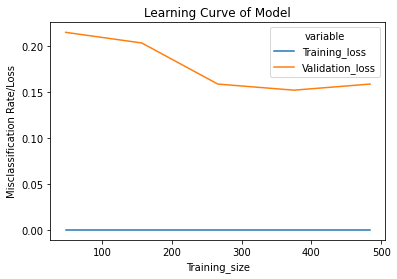

In [24]:
lc = learn_curve(x,y,1)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve of Model")
plt.ylabel("Misclassification Rate/Loss");

**Above graph shows the miscalculation v/s training size.
We see that as training dataset size increases, validation loss/miscalculation decreases and thus we can infer that we need more dataset for better prediction results**

In [25]:
# Create an object of SVC model and fit x,y values in it in order to generate pickle file
model_svm_argby=svm.SVC()
model_svm_argby.fit(x.values,y)

SVC()

In [26]:
# Create an object of KNN model and fit x,y values in it in order to generate pickle file
model_knn_argby=KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
model_knn_argby.fit(x.values,y)

KNeighborsClassifier()

In [27]:
# Create an object of GNB model and fit x,y values in it in order to generate pickle file
model_gnb_argby=GaussianNB()
model_gnb_argby.fit(x.values,y)

GaussianNB()

**GENERATION OF PICKLE FILES FOR ML MODEL**

In [28]:
# Creation of pickle file for svm model to predict argument by
model_file = "model_svm_argby.pkl"
with open(model_file,'wb') as f:
    pickle.dump(model_svm_argby, f)
    
# Creation of pickle file for knn model to predict argument by
model_file = "model_knn_argby.pkl"
with open(model_file,'wb') as f:
    pickle.dump(model_knn_argby, f)
    
# Creation of pickle file for gnb model to predict argument by
model_file = "model_gnb_argby.pkl"
with open(model_file,'wb') as f:
    pickle.dump(model_gnb_argby, f)

In [29]:
# Creation of pickle file for vectorizer to get the text into vector form for prediction using Machine Learning
model_file="model_vect_argby.pkl"
with open(model_file,'wb') as f:
    pickle.dump(vectorizer, f)

**PREDICTING THE ARGUMENT BY FOR GIVEN TEXT**

In [30]:
loaded_model_vect = pickle.load(open("model_vect_argby.pkl", 'rb'))
X_vec=loaded_model_vect.transform(["heard learned advocate mr waghmare for the applicant"])

In [32]:
loaded_model_argby = pickle.load(open("E:/git/SmartLawML/models/model_svm_argby.pkl", 'rb'))
o1 = loaded_model_argby.predict(X_vec.toarray())[0]
print(o1)

JUDGE
